# EpiEstim (python)


## Configure the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')
from datetime import datetime as dt
from datetime import timedelta
import glob
    
from Reff_functions import *
from Reff_constants import *
from scipy.stats import gamma

In [2]:
#Code taken from read_in_cases from Reff_functions. Preprocessing was not helpful for this situation.

case_file_date='29Jun'
path = "../data/COVID-19 UoM "+case_file_date+"*.xlsx"

for file in glob.glob(path):
    df_NNDSS = pd.read_excel(file,
                       parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                       dtype= {'PLACE_OF_ACQUISITION':str})
    df_NNDSS.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

   # df_NNDSS['date_inferred'] = df_NNDSS.TRUE_ONSET_DATE
  #  df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
  #  df_NNDSS.loc[df_NNDSS.date_inferred.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)    
df_NNDSS['imported'] = df_NNDSS.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
df_NNDSS['local'] = 1 - df_NNDSS.imported

df_interim = df_NNDSS[['NOTIFICATION_DATE','STATE','imported','local']] 
# Importantly, imported and local are indicator variables in df_interim.

#df_state = df_NNDSS[['NOTIFICATION_DATE','STATE','imported','local']].groupby(['STATE','NOTIFICATION_DATE']).sum()

df_interim = df_interim[~df_interim.NOTIFICATION_DATE.isna()] #Get rid of non-existent dates.


In [3]:
#Filter out territories
df_linel = df_interim[(df_interim['STATE']!='NT') & (df_interim['STATE']!='ACT')]
#Melt down so that imported and local are no longer columns. Allows multiple draws for infection date.
df_linel = df_linel.melt(id_vars = ['NOTIFICATION_DATE','STATE'], var_name = 'SOURCE',value_name='n_cases')

#Reset index or the joining doesn't work
df_linel = df_linel[df_linel.n_cases!=0]
df_linel = df_linel.reset_index()

## Part 1: Inferring infection dates
$\Lambda$ depends on the infection date (ID), while the data contains the notification date (ND). We obtain ID through the following relationship:
$$
ID = ND - reporting\_delay - incubation\_period.
$$

A gamma distribution was fitted to case data using the MLE algorithm to produce distributions for reporting delay and incubation period. 


In [4]:
##uncomment for debugging
# notification_dates = df_linel['NOTIFICATION_DATE']
# mean_rd = 5.47
# sd_rd = 4.04
# mean_inc = 2.0
# sd_inc = 1.41
# nreplicates = 3

##gamma draws take arguments (shape, scale)
def create_inf_dates(notification_dates, mean_rd=5.47, sd_rd=4.04,
                    mean_inc=2.0, sd_inc=1.41, nreplicates=1):

    nsamples = notification_dates.shape[0]

    #    DEFINE DELAY DISTRIBUTION
    #     mean_rd = 5.47
    #     sd_rd = 4.04
    scale_rd = mean_rd/(sd_rd)**2
    shape_rd = mean_rd/scale_rd

    # DEFINE INCUBATION PERIOD DISTRIBUTION
    #     mean_inc = 2.0
    #     sd_inc = 1.41
    scale_inc = mean_inc/(sd_inc)**2
    shape_inc = mean_inc/scale_inc

    #Draw from distributions - these are long vectors
    inc_period = np.random.gamma(shape_inc, scale_inc, size = (nsamples*nreplicates))
    rep_delay = np.random.gamma(shape_rd, scale_rd, size = (nsamples*nreplicates))

    #infection date is id_nd_diff days before notification date. This is also a long vector.
    id_nd_diff = inc_period + rep_delay

    #Minutes aren't included in df. Take the ceiling because the day runs from 0000 to 2359. This can still be a long vector.
    whole_day_diff = np.ceil(id_nd_diff) 
    time_day_diffmat = whole_day_diff.astype('timedelta64[D]').reshape((nsamples, nreplicates))

    #Vector must be coerced into a nsamples by nreplicates array. Then each column must be subtracted from notification_dates. 
    #Subtract days off of notification dates.

    notification_mat = np.tile(notification_dates, (nreplicates,1)).T #notification_dates is repeated as a column nreplicates times.

    infection_dates = notification_mat - time_day_diffmat

    return(infection_dates)

In [21]:
nreps = 1000
infdates = create_inf_dates(df_linel['NOTIFICATION_DATE'], nreplicates=nreps)
datecolnames = [*map(str,range(nreps))]
infdates_df = pd.DataFrame(infdates,columns = datecolnames)

#Add new infection_dates to the linelist data as columns. 
df_inf = pd.concat([df_linel, infdates_df], axis=1, verify_integrity=True)
df_inf.head()

,index,NOTIFICATION_DATE,STATE,SOURCE,n_cases,0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
0,0,2020-06-27,NSW,imported,1,2020-06-21,2020-06-19,2020-06-19,2020-06-18,2020-06-17,...,2020-06-18,2020-06-19,2020-06-19,2020-06-16,2020-06-20,2020-06-17,2020-06-21,2020-06-19,2020-06-16,2020-06-23
1,1,2020-06-26,NSW,imported,1,2020-06-17,2020-06-15,2020-06-18,2020-06-15,2020-06-19,...,2020-06-19,2020-06-20,2020-06-21,2020-06-15,2020-06-16,2020-06-22,2020-06-15,2020-06-19,2020-06-19,2020-06-20
2,2,2020-06-27,NSW,imported,1,2020-06-23,2020-06-18,2020-06-17,2020-06-18,2020-06-18,...,2020-06-16,2020-06-21,2020-06-19,2020-06-20,2020-06-21,2020-06-18,2020-06-15,2020-06-18,2020-06-21,2020-06-20
3,3,2020-06-26,NSW,imported,1,2020-06-18,2020-06-18,2020-06-19,2020-06-17,2020-06-18,...,2020-06-21,2020-06-15,2020-06-21,2020-06-19,2020-06-18,2020-06-19,2020-06-18,2020-06-19,2020-06-20,2020-06-20
4,4,2020-06-25,NSW,imported,1,2020-06-17,2020-06-16,2020-06-17,2020-06-20,2020-06-17,...,2020-06-16,2020-06-18,2020-06-16,2020-06-18,2020-06-18,2020-06-18,2020-06-18,2020-06-16,2020-06-16,2020-06-19


In [22]:
#Reshape so dates are index, case numbers are column values, samples still columns
df_combined = df_inf[['STATE','SOURCE',datecolnames[0],'n_cases']].groupby(['STATE', datecolnames[0],'SOURCE']).sum()
for cn in range(1,nreps):
    df_addin = df_inf[['STATE','SOURCE',datecolnames[cn],'n_cases']].groupby(['STATE', datecolnames[cn],'SOURCE']).sum()
    df_combined = pd.concat([df_combined,df_addin], axis=1, ignore_index = True)

#NaNs are inserted for missing values when concatenating. If it's missing, there were zero infections
df_combined[np.isnan(df_combined)]=0
df_combined.index.set_names(["STATE","INFECTION_DATE","SOURCE"], inplace=True)

#df_combined = df_combined.reset_index()
#Use indices for filling dates, so don't collapse them yet.
df_combined.head()
#It makes sense for df_combined to have considerably fewer rows, since rows now represent more than one case.

0    1    2    3    4    5    6    7    8    \
STATE INFECTION_DATE SOURCE                                                  
NSW   2020-01-06     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-07     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-08     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-09     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-10     imported  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   

                               9    ...  990  991  992  993  994  995  996  \
STATE INFECTION_DATE SOURCE         ...                                      
NSW   2020-01-06     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-07     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-08     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-09     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-10     imported  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

                               997  998  999  
STATE INFECTION_DATE SOURCE                   
NSW   2020-01-06     imported  0.0  0.0  0.0  
      2020-01-07     imported  0.0  0.0  0.0  
      2020-01-08     imported  0.0  0.0  0.0  
      2020-01-09     imported  0.0  0.0  0.0  
      2020-01-10     imported  0.0  0.0  0.0  

[5 rows x 1000 columns]

In [7]:
# Reindex to include days with zero total infections.
local_infs = df_combined.xs('local',level='SOURCE')
imported_infs = df_combined.xs('imported',level='SOURCE')
statelist = [*df_combined.index.get_level_values('STATE').unique()]

#Should all states have the same start date? Current code starts from the first case in each state.
#For the same start date:
local_statedict = dict(zip(statelist, np.repeat(None, len(statelist))))
imported_statedict = dict(zip(statelist, np.repeat(None, len(statelist))))

start_date = np.datetime64("2020-02-01")

#Determine end dates as the last infected date by state.
index_only = df_combined.index.to_frame()
index_only = index_only.reset_index(drop=True)
maxdates = df_combined.reset_index().groupby(['STATE'])['INFECTION_DATE'].max()

for aus_state in statelist:
    state_data = local_infs.xs(aus_state, level='STATE')
    #start_date = state_data.index.min()
    
    #dftest.index=dftest.reindex(alldates, fill_value=0)
    
    alldates = pd.date_range(start_date, maxdates[aus_state]) #All days from start_date to the last infection day.
    local_statedict[aus_state] = state_data.reindex(alldates, fill_value=0)
    
for aus_state in statelist:
    state_data = imported_infs.xs(aus_state, level='STATE')
    alldates = pd.date_range(start_date, maxdates[aus_state])
    imported_statedict[aus_state] = state_data.reindex(alldates, fill_value=0)

In [8]:
#Convert dictionaries to data frames
df_local_inc_zeros = pd.concat(local_statedict)
df_local_inc_zeros['SOURCE']='local'
df_imp_inc_zeros = pd.concat(imported_statedict)
df_imp_inc_zeros['SOURCE']='imported'

In [9]:
#Merge dataframes and reindex. 
df_inc_zeros = pd.concat([df_local_inc_zeros, df_imp_inc_zeros])

df_inc_zeros = df_inc_zeros.reset_index()
df_inc_zeros= df_inc_zeros.groupby(['level_0',"level_1","SOURCE"]).sum()
df_inc_zeros.index = df_inc_zeros.index.rename(['STATE','INFECTION_DATE',"SOURCE"])

In [10]:
#Finished data manipulation
## dataframe is now indexed by infection date, columns are different samples
## of possible infection dates for cases and values are a realisation
## of the number of cases infected on that day

df_inc_zeros.head(20)

0    1    2    3    4    5    6    7    8   \
STATE INFECTION_DATE SOURCE                                                  
NSW   2020-02-01     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-02     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-03     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-04     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-05     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-06     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-07     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-08     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-09     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-10     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                9   ...   90   91   92   93   94   95   96  \
STATE INFECTION_DATE SOURCE         ...                                      
NSW   2020-02-01     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-02     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-03     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-04     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-05     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-06     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-07     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-08     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-09     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-02-10     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                97   98   99  
STATE INFECTION_DATE SOURCE                   
NSW   2020-02-01     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-02-02     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-02-03     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-02-04     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-02-05     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-02-06     imported  0.0

In [11]:
# unit test to ensure min and max dates captures all imputations of 
# infection dates
summary = np.sum(df_inc_zeros, axis=0).describe() #Differences in numbers: start date?
assert summary.loc['max'] == summary.loc['min'], "Min number of cases does not match max number, dates have truncated cases"


## Part 2: Calculating Lambda

$$
\Lambda_t(w_s) = \sum_{s=1}^t (I_{t-s}^{local} + I_{t-s}^{imported})w_s = \sum_{s=1}^t I_{t-s}w_s,
$$
where $w_s$ is the probability that the generation interval is $s$ and $I_t$ is the number of infected individuals at time $t$. 

### Part 2a: Discretizing the gamma generation interval distribution

In the formula for $\Lambda_t$, we sum over $w$. We should consider generation interval as a discrete random variable here. 

In [37]:
def generate_lambda(infection_dates, mean_gen=2.5, sd_gen=1.75, trunc_day=21,shift=0):
    """
    Given array of infection_dates (N_dates by N_samples), where values are possible
    number of cases infected on this day, generate the force of infection Lambda_t,
    a N_dates-tau by N_samples array.
    """
    from scipy.stats import gamma
 
    scale_gen = mean_gen/(sd_gen)**2
    shape_gen = mean_gen/scale_gen
    

    xmids = [x+shift for x in range(trunc_days+1)] #Find midpoints for discretisation
    gamma_vals = gamma.pdf(xmids, a=shape_gen, scale=scale_gen) #double check parameterisation of scipy
    #renormalise the pdf
    disc_gamma = gamma_vals/sum(gamma_vals)
    
    ws = disc_gamma[:trunc_day]
    lambda_t = np.zeros(shape=(infection_dates.shape[0]-trunc_day+1, infection_dates.shape[1]))
    for n in range(infection_dates.shape[1]):
        lambda_t[:,n] = np.convolve(infection_dates[:,n], ws, mode='valid')
    return lambda_t
    
    
def lambda_all_states(df_infection):
    """
    Use geenrate lambda on every state
    """
    statelist = [*infection_dates.index.get_level_values('STATE').unique()]
    
    lambda_dict ={}
    for state in statelist:
        lambda_dict[state] = generate_lambda(df_infection.xs(state, level='STATE'))
    
    return lambda_dict

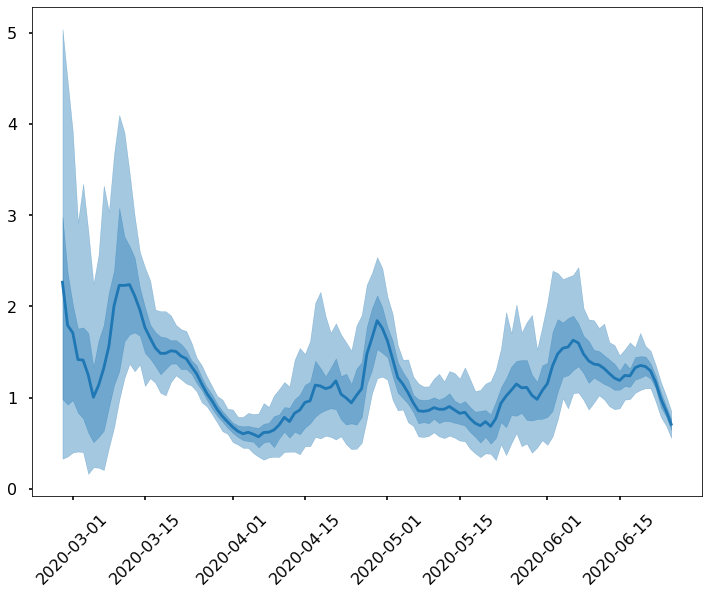

In [58]:
#test run on a state

df_VIC = df_inc_zeros.xs(('VIC','local'),level=('STATE','SOURCE'))
lambda_VIC = generate_lambda(df_VIC.values )


a,b,R = Reff_from_case(df_VIC.values,lambda_VIC,prior_a=1, prior_b=2)

R_summary = generate_summary(R)

plot_Reff(R_summary, dates= df_VIC.index.values[27:])

plt.show()

In [13]:
#Define gamma distribution for generation interval
mean_gen = 2.5
sd_gen = 1.75
scale_gen = mean_gen/(sd_gen)**2
shape_gen = mean_gen/scale_gen


In [14]:
## Plot gamma pdf over random samples from distribution
# xrange = np.linspace(0,25,150)

# fig,ax = plt.subplots(figsize=(12,9))
# x = np.random.gamma(shape_gen, scale_gen, size = 10000)
# print("Generation time: \nMean: %f.2" %np.mean(x))
# print("Std: %f.2" %np.std(x))
# w = ax.hist(x,bins=40, density=True)
# ax.set_title("Generation time distribution")
# ax.plot(xrange, gamma.pdf(xrange, a=shape_gen, scale=scale_gen), linewidth=4,alpha=0.8)

In [15]:
trunc_days = 21
shift=0
xmids = [x+shift for x in range(trunc_days+1)] #Find midpoints for discretisation
gamma_vals = gamma.pdf(xmids, a=shape_gen, scale=scale_gen)
disc_gamma = gamma_vals/sum(gamma_vals)

In [16]:
#Discretisation error check (should sum to 1)

print("Sum of gamma values is " + str(sum(gamma_vals))+"; \n Sum of discretised gamma values is " + str(sum(disc_gamma)))

Sum of gamma values is 0.9936691617045523; 
 Sum of discretised gamma values is 1.0000000000000002


Text(0.5, 0, 'Days')

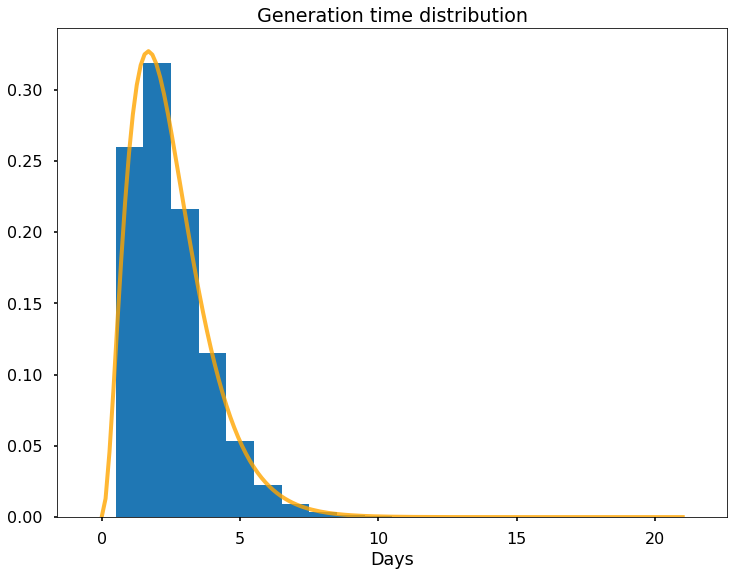

In [17]:
xrange = np.linspace(0,trunc_days,150)
fig,ax = plt.subplots(figsize=(12,9))
w = ax.bar(xmids,height=disc_gamma, width=1)
ax.set_title("Generation time distribution")
ax.plot(xrange, gamma.pdf(xrange, a=shape_gen, scale=scale_gen), linewidth=4,alpha=0.8, color="orange")
ax.set_xlabel('Days')

### Part 2b: Actually calculating $\Lambda$

In [18]:
# We use the total number of infected individuals, so use total I.
I_total = df_total.drop('local',1)

#Summing over s from 1 to t means that t is the maximum value of the generation interval. 
#21 here. So we should filter the data to 21 days before whenever 
I_total=I_total.reset_index()

#Test on one state before parallelising?
onestate='NSW'
input_state = I_total[I_total.STATE=='NSW']


tmax = input_state['infection_date'].max()

#input a vector of infection dates and total values.
tstart= tmax-np.timedelta64(trunc_days,'D')


relevant_dates = pd.date_range(tstart, tmax-np.timedelta64(1,'D'))
reldates = input_state['total'][input_state.infection_date.isin(relevant_dates)]
ws = [*reversed(disc_gamma[1:(trunc_days+1)])]
lambda_t=sum(reldates*ws)

NameError: name 'df_total' is not defined

In [ ]:
lambda_t

## 3. Sample from the posterior

Using Cori et al. 2013, the posterior distribution of $R_{t,\tau}$ is a Gamma distribution with parameters shape and scale

\begin{equation}
\left( a + \sum^t_{s = t - \tau +1} I_s , \frac{1}{\frac{1}{b} + \sum^t_{ s = t-\tau + 1} \Lambda_s } \right)
\end{equation}

In [44]:
def Reff_from_case(cases_by_infection, lamb, prior_a=1, prior_b=5, tau=7, samples=1000):
    """
    Using Cori at al. 2013, given case incidence by date of infection, and the force
    of infection \Lambda_t on day t, estimate the effective reproduction number at time
    t with smoothing parameter \tau.
    
    cases_by_infection: A T by N array, for T days and N samples 
    lamb : A T by N array, for T days and N samples
    """
    csum_incidence = np.cumsum(cases_by_infection, axis = 0)
    #remove first few incidences to align with size of lambda
    csum_incidence = csum_incidence[20:,:]
    csum_lambda = np.cumsum(lamb, axis =0)
    
    roll_sum_incidence = csum_incidence[tau:, :] - csum_incidence[:-tau, :]
    roll_sum_lambda = csum_lambda[tau:,:] - csum_lambda[:-tau,:]
    a = prior_a + roll_sum_incidence
    b = 1/(1/prior_b + roll_sum_lambda)
    
    
    
    #Use array inputs to output to same size
    #inputs are T-tau by N, output will be T-tau by N
    return a,b, np.random.gamma(a,b) #shape, scale

def generate_summary(samples, dates_by='rows'):
    """
    Given an array of samples (T by N) where rows index the dates, 
    generate summary statistics and quantiles
    """
    
    if dates_by=='rows':
        #quantiles of the columns
        ax = 1
    else:
        #quantiles of the rows
        ax = 0
    mean = np.mean(samples, axis = ax)
    bottom, lower, median, upper, top = np.quantile(samples,
                                                     (0.05, 0.25, 0.5, 0.75, 0.95),
                                                     axis =ax)
    std = np.std(samples, axis = ax)
    output = {
        'mean':mean,
        'std':std,
        'bottom':bottom,
        'lower':lower,
        'median':median,
        'upper':upper,
        'top': top,
        
    }
    return output

def plot_Reff(Reff:dict, dates=None):
    """
    Given summary statistics of Reff as a dictionary, plot the distribution over time
    """
    import matplotlib.pyplot as plt
    
    plt.style.use('seaborn-poster')
    from datetime import datetime as dt
    
    fig, ax = plt.subplots(figsize=(12,9))
    
    if dates is None:
        dates = range(len(Reff['mean']))
        
    ax.plot(dates, Reff['mean'])
    
    ax.fill_between(dates, Reff['lower'],Reff['upper'], alpha=0.4, color = 'C0')
    ax.fill_between(dates, Reff['bottom'],Reff['top'], alpha=0.4, color= 'C0')
    
       #grid line at R_eff =1
    ax.set_yticks([1],minor=True,)
    #ax.set_yticks([0,2,3],minor=False)
    #ax.set_yticklabels([0,2,3],minor=False)
    ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    
    ax.tick_params(axis='x', rotation = 45)
    
    return fig, ax
    

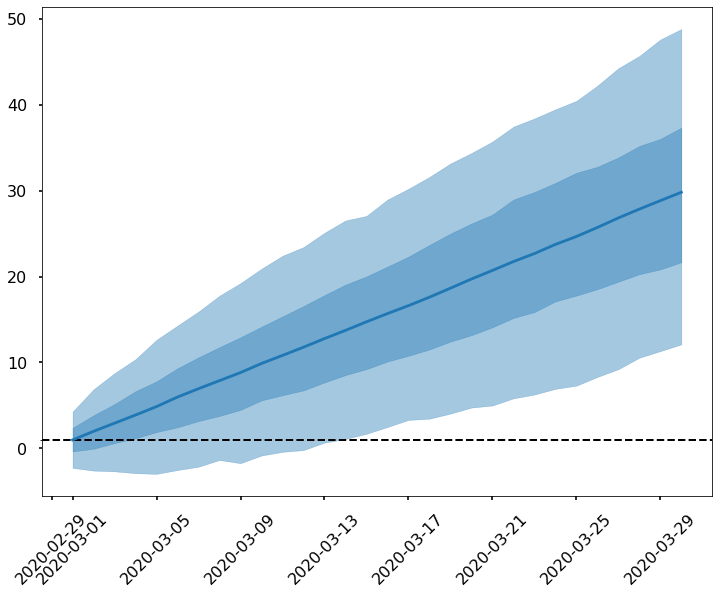

In [20]:
## plot results


test = np.random.normal(loc=1, scale = 2, size =(30,1000))
test_c = np.cumsum(test, axis=0)

test_sum = generate_summary(test_c)

fig, ax = plot_Reff(test_sum, 
                    dates=pd.date_range(start='2020-03-01', periods=30))

plt.show()